# RNN for 3D keypoint generation

## Build network with Keras

In [1]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import time
import math
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt

# Hacky. Is there a better way to load local modules?
%run ../renderer/common.py

## Import keypoint sequences

In [2]:
keypoints = np.load('../data/train/seq_001/pose3d.npz', allow_pickle=True)
keypoints = keypoints['arr_0']
print("-----------")
print(len(keypoints))

-----------
901


### Check data

**Note:** In order to render a video based on the pose3D data, please run `python renderer/render_pose3d_matplot.py ../data/train/seq_001/pose3d.npz --frames 300`

In [3]:
print(keypoints[:, 0])

[[-1.25746683e-05  1.04208084e-07  8.78713608e-01]
 [-1.24831749e-05 -1.67165126e-08  8.78713667e-01]
 [-1.24098260e-05 -9.28339432e-08  8.78713608e-01]
 ...
 [-9.33815500e-07 -5.53773134e-07  8.78713250e-01]
 [-3.99713372e-07 -7.42826160e-07  8.78712952e-01]
 [-1.53330348e-07 -6.64569598e-07  8.78712952e-01]]


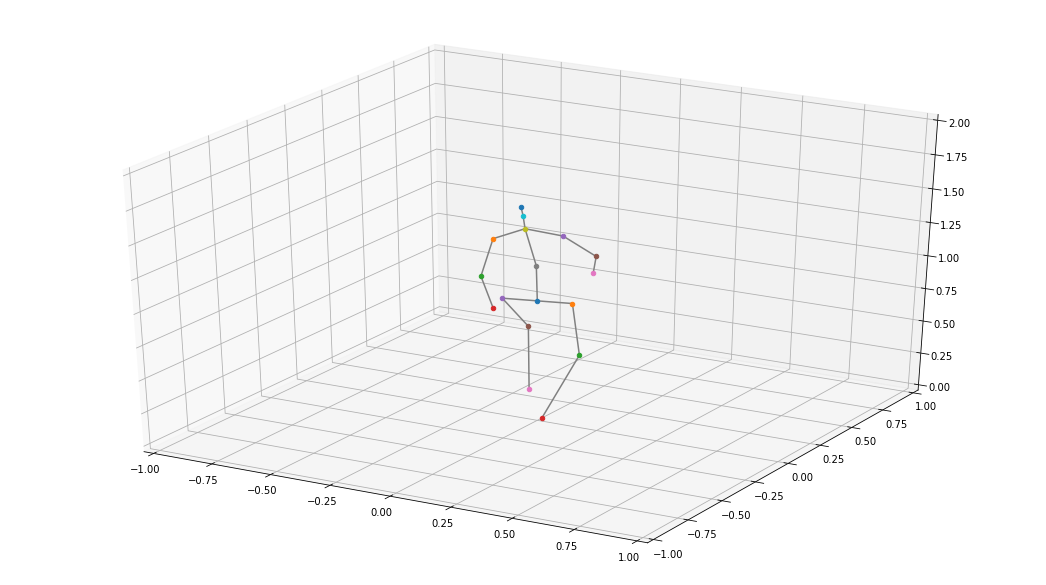

In [4]:
fig, ax = init_plot()
plot_pose(ax, keypoints[400])

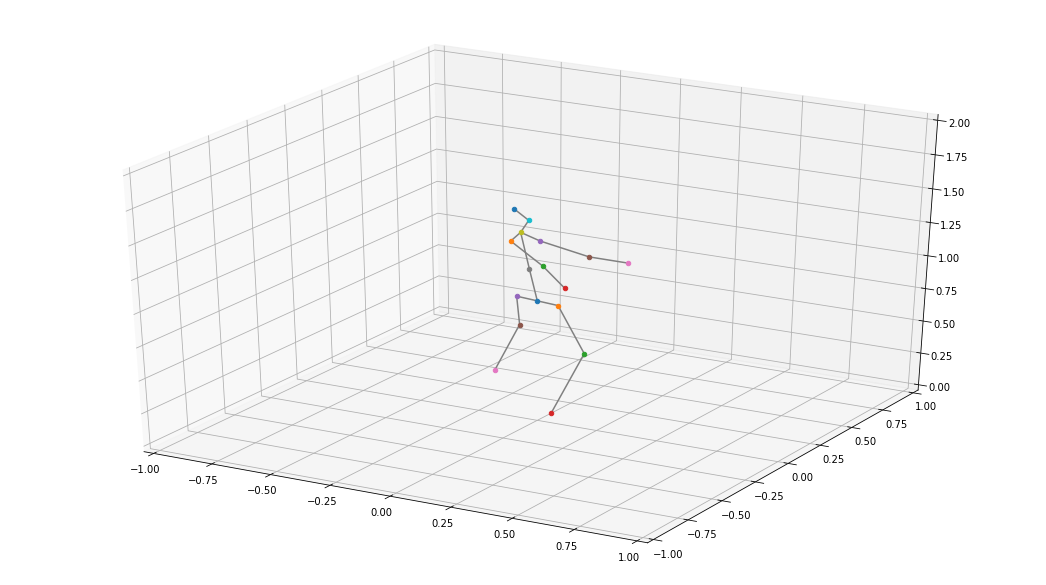

In [5]:
fig, ax = init_plot()
plot_pose(ax, keypoints[500])

In [6]:
# split into train and test sets
train_size = int(len(keypoints) * 0.67)
test_size = len(keypoints) - train_size
train, test = keypoints[0:train_size,:], keypoints[train_size:len(keypoints),:]
print("-------------------")
print(len(train), len(test))

-------------------
603 298


In [27]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [28]:
np.shape(trainY)

(601, 17, 3)

In [29]:
# reshape input to be [samples, time steps, features]
print(trainX)
print(trainX.shape[1])

trainX = np.reshape(trainX, (trainX.shape[0], 51, trainX.shape[1]))
trainY = np.reshape(trainY, (trainY.shape[0], 51))
testX = np.reshape(testX, (testX.shape[0], 51, testX.shape[1]))

print(trainX)

[[[[-1.25746683e-05  1.04208084e-07  8.78713608e-01]
   [ 1.15716755e-01 -1.30506102e-02  8.74802351e-01]
   [ 2.66533881e-01  8.72060657e-03  5.02278566e-01]
   ...
   [ 6.26765937e-03  1.13337994e-01  1.33133364e+00]
   [ 3.21331322e-02  3.60054582e-01  1.38033271e+00]
   [-1.50704831e-01  4.82339114e-01  1.32347190e+00]]]


 [[[-1.24831749e-05 -1.67165126e-08  8.78713667e-01]
   [ 1.15357958e-01 -1.34051871e-02  8.74607921e-01]
   [ 2.65815973e-01  6.94319606e-03  5.01588166e-01]
   ...
   [ 6.24468178e-03  1.13035023e-01  1.33107936e+00]
   [ 3.22045237e-02  3.58990192e-01  1.38070297e+00]
   [-1.50025368e-01  4.83436435e-01  1.32386851e+00]]]


 [[[-1.24098260e-05 -9.28339432e-08  8.78713608e-01]
   [ 1.14861608e-01 -1.41135557e-02  8.74583602e-01]
   [ 2.65594631e-01  5.88572025e-03  5.01607060e-01]
   ...
   [ 6.16089627e-03  1.12351298e-01  1.33059323e+00]
   [ 3.21275592e-02  3.57862532e-01  1.38078654e+00]
   [-1.49428219e-01  4.84736085e-01  1.32410860e+00]]]


 ...


 [[[ 1

## Training

https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [30]:
model = keras.Sequential()
model.add(layers.LSTM(4, input_shape=(51, look_back)))
model.add(layers.Dense(51))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(optimizer='sgd', loss='mse')
# model.compile(optimizer='sgd', loss='mae')

def train_predict_plot():
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    for i in range(400, 401):
        plot_pose(ax, trainPredict[i])

In [31]:
train_predict_plot()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
601/601 - 20s - loss: 0.0889


IndexError: invalid index to scalar variable.